In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

### 定义稠密块

In [5]:
def conv_block(input_channels,num_channels):
    return nn.Sequential(nn.BatchNorm2d(input_channels),
                         nn.ReLU(),
                         nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1))

一个稠密块由多个卷积块组成，每个卷积块使用相同数量的输出信道。 然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。

In [6]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                            num_channels*i + input_channels,num_channels))
        self.net = nn.Sequential(*layer)
    def forward(self,X):
        for blk in self.net:
            Y=blk(X)
            #连接通道维度上每一个块的输入和输出
            X = torch.cat((X,Y),dim=1)
        return X

我们定义一个有 2 个输出通道数为 10 的 DenseBlock。 使用通道数为 3 的输入时，我们会得到通道数为  3+2×10=23  的输出。 卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为增长率（growth rate）。

In [7]:
blk=DenseBlock(2,3,10)
X=torch.randn(4,3,8,8)
Y=blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

### 过渡层
由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。 而过渡层可以用来控制模型复杂度。 它通过  1×1  卷积层来减小通道数，并使用步幅为 2 的平均汇聚层减半高和宽，从而进一步降低模型复杂度。

In [8]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
            nn.BatchNorm2d(input_channels),nn.ReLU(),
            nn.Conv2d(input_channels,num_channels,kernel_size=1),
            nn.AvgPool2d(kernel_size=2,stride=2))

对上一个例子中稠密块的输出使用通道数为 10 的过渡层。 此时输出的通道数减为 10，高和宽均减半。

In [9]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

### DenseNet模型

##### DenseNet 首先使用同 ResNet 一样的单卷积层和最大汇聚层。

In [10]:
b1 = nn.Sequential(
        nn.Conv2d(1,64,kernel_size=7,stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

类似于 ResNet 使用的 4 个残差块，DenseNet 使用的是 4 个稠密块。 与 ResNet 类似，我们可以设置每个稠密块使用多少个卷积层。 这里我们设成 4，从而与 7.6节 的 ResNet-18 保持一致。 稠密块里的卷积层通道数（即增长率）设为 32，所以每个稠密块将增加 128 个通道。

在每个模块之间，ResNet 通过步幅为 2 的残差块减小高和宽，DenseNet 则使用过渡层来减半高和宽，并减半通道数。

In [11]:
#num_channels 为当前的通道数
num_channels,growth_rate = 64,32
num_convs_in_dense_blocks=[4,4,4,4]
blks=[]
for i,num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs,num_channels,growth_rate))
    #上一个稠密快的输出的通道数
    num_channels +=num_convs*growth_rate
    #在稠密块之间添加一个转换层，使通道数减半
    if i!=len(num_convs_in_dense_blocks)-1:
        blks.append(transition_block(num_channels,num_channels//2))
        num_channels = num_channels//2

与 ResNet 类似，最后接上全局汇聚层和全连接层来输出结果。



In [12]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

loss 0.158, train acc 0.942, test acc 0.725
2297.3 examples/sec on cuda:0


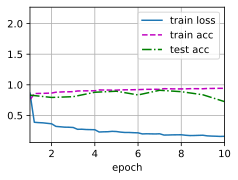

In [13]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())